In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [6]:

# Define functions
def read_edge_usage(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            res1 = int(parts[1])
            res2 = int(parts[3].rstrip(':'))
            weight = int(parts[4])
            edges.append((res1, res2, weight))
    return edges

def read_pdb(file_path):
    pdb_data = {}
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("ATOM"):
                res_number = int(line[22:26].strip())
                res_type = line[17:20].strip()
                chain = line[21].strip()
                pdb_data[res_number] = (res_type, chain)
    return pdb_data

def get_domain(residue):
    domain_ranges = {
        'NTD A': range(13, 220),
        'NTD B': range(1141, 1420),
        'NTD C': range(2269, 2548),
        'RBD A': range(331, 529),
        'RBD B': range(1459, 1657),
        'RBD C': range(2587, 2785),
        'RBM A': range(437, 509),
        'RBM B': range(1565, 1637),
        'RBM C': range(2693, 2765),
        'CTD2 A': range(529, 590),
        'CTD2 B': range(1657, 1718),
        'CTD2 C': range(2785, 2846),
        'CTD3 A': range(590, 676),
        'CTD3 A2': range(1691, 698),
        'CTD3 B1': range(1718, 1804),
        'CTD3 B2': range(1819, 1826),
        'CTD3 C1': range(2846, 2932),
        'CTD3 C2': range(2947, 2954),
        'FCS A': range(675, 691),
        'FCS B': range(1803, 1819),
        'FCS C': range(2931, 2947),
        'FP': range(817, 835),
        'FP2': range(1945, 1963),
        'FP3': range(3073, 3091),
        'FPPR': range(835, 856),
        'FPPR2': range(1963, 1984),
        'FPPR3': range(3091, 3112),
        'HR1': range(910, 986),
        'HR1-2': range(2038, 2114),
        'HR1-3': range(3166, 3242),
        'CH': range(985, 1035),
        'CH2': range(2113, 2163),
        'CH3': range(3241, 3291),
        'CD': range(1035, 1069),
        'CD2': range(2163, 2197),
        'CD3': range(3291, 3325),
        'Chain G': range(3389, 3880),
        'Chain M': range(3880, 3999),
        'Chain N': range(4419, 4538),
        'Chain O': range(4538, 4657),
        'Chain P': range(3999, 4139),
        'Chain Q': range(4279, 4419),
        'Chain R': range(4139, 4279)
    }
    
    for domain, residues in domain_ranges.items():
        if residue in residues:
            return domain
    return None

def generate_output_file(edges, pdb_data, output_file):
    with open(output_file, 'w') as file:
        for res1, res2, weight in edges:
            res1_info = pdb_data.get(res1, ("Unknown", "Unknown"))
            res2_info = pdb_data.get(res2, ("Unknown", "Unknown"))
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            file.write(f"Edge {res1}-{res2}-{weight}; {res1_info[0]}-{domain1}-{res1_info[1]} -> {res2_info[0]}-{domain2}-{res2_info[1]}\n")

def create_domain_residue_list(edges, pdb_data):
    domain_residues = defaultdict(set)
    for res1, res2, _ in edges:
        domain1 = get_domain(res1)
        domain2 = get_domain(res2)
        if domain1:
            domain_residues[domain1].add(res1)
        if domain2:
            domain_residues[domain2].add(res2)
    return domain_residues

def plot_domain_weights(edge_files, pdb_data):
    domain_weights_list = []
    
    for file in edge_files:
        edges = read_edge_usage(file)
        domain_weights = defaultdict(int)
        for res1, res2, weight in edges:
            domain1 = get_domain(res1)
            domain2 = get_domain(res2)
            if domain1:
                domain_weights[domain1] += weight
            if domain2:
                domain_weights[domain2] += weight
        domain_weights_list.append(domain_weights)
    
    all_domains = set()
    for weights in domain_weights_list:
        all_domains.update(weights.keys())
    

    normalized_weights = {}
    for domain in all_domains:
        domain_values = [weights.get(domain, 0) for weights in domain_weights_list]
        total_weight = sum(domain_values)
        if total_weight > 0:
            normalized_weights[domain] = (sum(domain_values) / len(domain_values), pd.Series(domain_values).std())
    
    # Plotting
    domains = list(normalized_weights.keys())
    means = [normalized_weights[d][0] for d in domains]
    stds = [normalized_weights[d][1] for d in domains]
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(20, 10))
    plt.bar(domains, means, yerr=stds, capsize=5, color='skyblue')
    plt.xlabel('Domains')
    plt.ylabel('Normalized Weights')
    plt.title('Normalized Addition of Weights Corresponding to Each Domain (with Std Dev)')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()



In [7]:
pwd

'/Users/carlacalvo/Documents/GitHub/MDrepo/spike'

For range of 3 chains:         'NTD': set(range(13, 220)).union(range(1141, 1420)).union(range(2269, 2548)),

In [8]:
# File paths
pdb_file_path = "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/combined.pdb"
edge_files = ["/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep1/dist14/test_plot/egde_usage_1000.txt", "/Users/carlacalvo/Carla/wisp/wisp_spm/analysis_folder/mucins/nocal/wt/rep2/dist14/edge_usage_1000.txt"]  # List all edge files here

In [9]:
# Read PDB data
pdb_data = read_pdb(pdb_file_path)

In [10]:

# Generate output for each edge file
for edge_file in edge_files:
    output_file_path = edge_file.replace('.txt', '_info.txt')
    edges = read_edge_usage(edge_file)
    generate_output_file(edges, pdb_data, output_file_path)

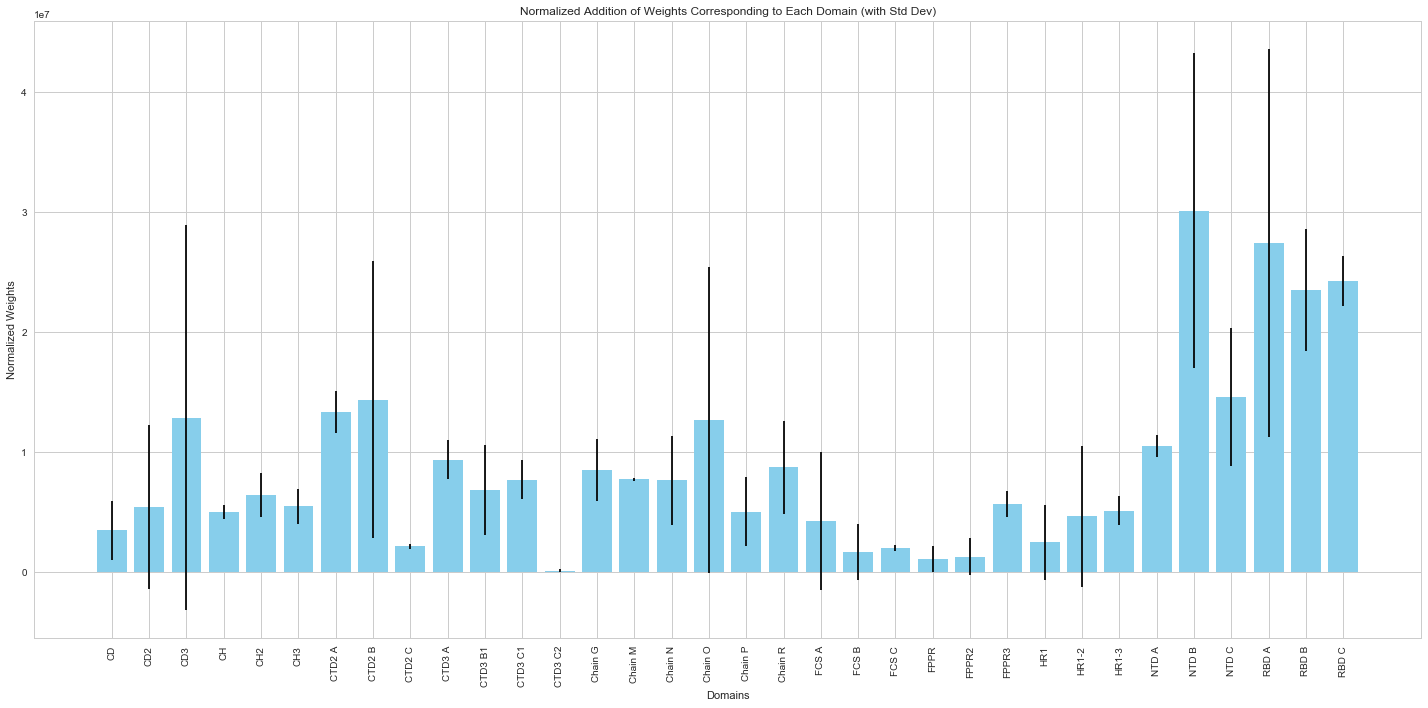

In [11]:
# Plot domain weights with standard deviation
plot_domain_weights(edge_files, pdb_data)